In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from mpl_toolkits import mplot3d

from numba import njit, float64, vectorize


from csr2d.wake import green_mesh
from csr2d.convolution import fftconvolve2

import time

import concurrent.futures as cf


import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

In [2]:
# Chris's parameters 
gamma = 20000
rho = 1.0 # Bend radius in m

# Total charge
#Nb = 6.25e9
#Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

sigma_x  = 10e-6
sigma_z  = 10e-6
# Bypassing the beam, use smooth Gaussian distribution

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

nz = 201
nx = 201
zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
Z, X = np.meshgrid(zvec, xvec, indexing='ij')
lambda_grid_filtered = lamb_2d(Z,X)
lambda_grid_filtered_prime = lamb_2d_prime(Z,X)
dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

In [3]:
Es_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF')

/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:223: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func_z, z-dz/2, z+dz/2, points = points, epsrel=1e-6, limit=100)[0]
/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:223: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(func_z, z-dz/2, z+dz/2, points = points, epsrel=1e-6, limit=100)[0]
/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:223: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perha

In [4]:
@njit
def boundary_convolve(case, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Green, phi=None):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    z_observe_index = np.argmin(np.abs(zvec - z_observe))

    nz = len(zvec)
    nx = len(xvec)
    cond = np.zeros( (nz,nx) ) # To be filled with True and Flase
    
    # Boundary condition 
    temp = (x_observe - xvec)/rho
    
    if case =='A':
        zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
        for i in range(nx):
            cond[:,i]  = (zvec > z_observe - zi_vec[i])   
        factor = (1/gamma**2 / rho**2)
            
    elif case =='B':
        zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
        zo_vec = -beta*np.abs(x_observe - xvec)
        for i in range(nx):
            cond[:,i]  = (zvec > z_observe - zo_vec[i]) | (zvec < z_observe - zi_vec[i])
        factor = (beta**2 / rho**2)
    else:
        print('Unknown case !!!')
        #raise ValueError(f'Unknown case: {case} !!!')
        

    lambda_grid_filtered_bounded = np.where(cond, 0, lambda_grid_filtered)
    
    conv = my_2d_convolve2(lambda_grid_filtered_bounded, Green, z_observe_index, x_observe_index) 
    
    return conv*factor*(dx*dz)

In [ ]:
phi_vec = [0.02, 0.03, 0.05, 0.06, 0.09, 0.12]

In [142]:
boundary_convolve('B', 0.00001, 0.00001, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF, phi = 0.1)

-437544.9610557041

In [108]:
#@vectorize([float64(float64, float64, float64, float64)], target='parallel')
@vectorize([float64(float64, float64)])
def boundary_convolve_Ws_A_super(z_observe, x_observe):
    return boundary_convolve('A', z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, phi=phi)

In [110]:
def boundary_convolve_Ws_A_super(z_observe, x_observe):
    return boundary_convolve('A', z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, phi=phi)

def boundary_convolve_Ws_B_super(z_observe, x_observe):
    return boundary_convolve('B', z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF, phi=phi)

In [144]:
phi = 0.05


In [107]:
phi = 0.05
Es_case_A_grid = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_A', phi =0.05)

component: Es_case_A
Change to internal coordinates...


In [117]:
boundary_convolve('A', 0.0001, 0.0001, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, phi=0.12)

49043.119211827856

In [74]:
boundary_convolve_A_super(0.0001, 0.0001)

1152.3275221773865

In [76]:

haha = boundary_convolve_A_super(Z, X)

In [80]:
map(boundary_convolve_Ws_A_super, Z[0:4], X[0:4])

In [111]:
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    t1 = time.time()
    kaka = np.array(list(executor.map(boundary_convolve_Ws_A_super ,Z.flatten(), X.flatten())))
    kaka2 = kaka.reshape(Z.shape)
    t2 = time.time()
print('This takes,', t2-t1, 's')

This takes, 62.03893280029297 s


In [145]:
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    t1 = time.time()
    kaka = np.array(list(executor.map(boundary_convolve_Ws_B_super ,Z.flatten(), X.flatten())))
    kaka2 = kaka.reshape(Z.shape)
    t2 = time.time()
print('This takes,', t2-t1, 's')

This takes, 92.44159865379333 s


In [97]:
kaka2 = np.array(kaka)
kaka2 = kaka2.reshape(Z.shape)

In [88]:
x_observe_index = np.argmin(np.abs(xvec - x_observe))

In [89]:
x_observe_index 

150

Text(0.5, 0.92, 'psi_s at the first step of chicane')

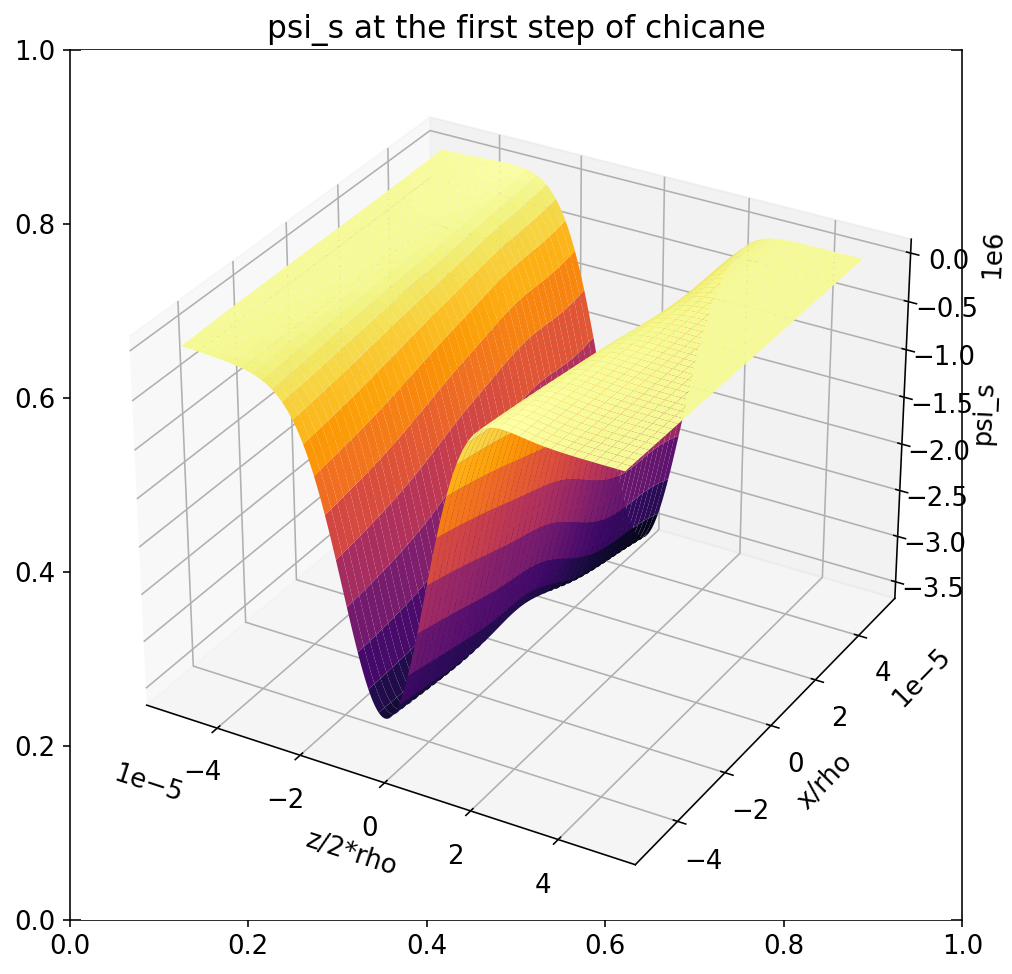

In [141]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(Z,X, kaka2, cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

In [7]:
@njit
def my_2d_convolve2(g1, g2, ix1, ix2):
    """
    Convolution for a specific observation point only, at (ix1, ix2)
    Assumption: g2 is a double-sized grid of g1. 
    
    Parameters
    ----------
    g1 : 2D array of size (nz, nx)
    
    g2 : 2D array of size (2*nz, 2*nx)
        
    ix1, ix2 : int
    
    Returns:
        A single value, the convolution result at (ix1, ix2)
    """
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    
    sums = 0
    for i in range(d1):
        for j in range(d2):
            sums+= g1[i,j]*g2_cut[i,j]
    return sums

@njit
def transient_calc_lambda_B(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Gs):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    z_observe_index = np.argmin(np.abs(zvec - z_observe))

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec)
    
    nz = len(zvec)
    nx = len(xvec)
    
    # Allocate array for histogrammed data
    cond = np.zeros( (nz,nx) )
    
    for i in range(nx):
        cond[:,i]  = (zvec > z_observe - zo_vec[i]) | (zvec < z_observe - zi_vec[i])
    

    lambda_grid_filtered_bounded = np.where(cond, 0, lambda_grid_filtered)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_bounded, Gs, z_observe_index, x_observe_index) 
    #conv_x = my_2d_convolve2(lambda_grid_filtered_bounded, Gx, z_observe_index, x_observe_index)  
    
    return conv_s*  (beta**2 / abs(rho)) *(dx*dz)

@njit
def transient_calc_lambda_A(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Gs):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    z_observe_index = np.argmin(np.abs(zvec - z_observe))

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec)
    
    nz = len(zvec)
    nx = len(xvec)
    
    # Allocate array for histogrammed data
    cond = np.zeros( (nz,nx) )
    
    for i in range(nx):
        cond[:,i]  = (zvec > z_observe - zi_vec[i])
    
    lambda_grid_filtered_bounded = np.where(cond, 0, lambda_grid_filtered)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_bounded, Gs, z_observe_index, x_observe_index) 
    #conv_x = my_2d_convolve2(lambda_grid_filtered_bounded, Gx, z_observe_index, x_observe_index)  
    
    return conv_s*   (1/gamma**2 / rho**2) *(dx*dz)



@njit
def transient_calc_lambda_D(phi_m, lamb, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Gs):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    z_observe_index = np.argmin(np.abs(zvec - z_observe))

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    #zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec)
    
    zid_vec = rho*(phi_m + lamb - beta*np.sqrt(lamb**2 + temp**2 + 4*(1+temp)*np.sin(phi_m/2)**2 + 2*lamb*np.sin(phi_m)))
    zod_vec = rho*(lamb - beta*np.sqrt(lamb**2 + temp**2))
    
    nz = len(zvec)
    nx = len(xvec)
    
    # Allocate array for histogrammed data
    cond = np.zeros( (nz,nx) )
    
    for i in range(nx):
        cond[:,i]  = (zvec > z_observe - zod_vec[i]) | (zvec < z_observe - zid_vec[i])
    

    lambda_grid_filtered_bounded = np.where(cond, 0, lambda_grid_filtered)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_bounded, Gs, z_observe_index, x_observe_index) 
    #conv_x = my_2d_convolve2(lambda_grid_filtered_bounded, Gx, z_observe_index, x_observe_index)  
   
    return conv_s *  (beta**2 / abs(rho)) *(dx*dz)

@njit
def transient_calc_lambda_E(lamb, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Gs):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    z_observe_index = np.argmin(np.abs(zvec - z_observe))

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    #zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec)
    
    zod_vec = rho*(lamb - beta*np.sqrt(lamb**2 + temp**2))
    zo_vec = -beta*np.abs(x_observe - xvec)
    
    nz = len(zvec)
    nx = len(xvec)
    
    # Allocate array for histogrammed data
    cond = np.zeros( (nz,nx) )

    for i in range(nx):
        cond[:,i]  = (zvec > z_observe - zo_vec[i]) | (zvec < z_observe - zod_vec[i])
    

    lambda_grid_filtered_bounded = np.where(cond, 0, lambda_grid_filtered)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_bounded, Gs, z_observe_index, x_observe_index) 
    #conv_x = my_2d_convolve2(lambda_grid_filtered_bounded, Gx, z_observe_index, x_observe_index)  
   
    
    return conv_s * (1/gamma**2) *(dx*dz)

# Case E

In [77]:
Es_case_E_grid_IGF = green_mesh((nz, nx), (dz, dx), gamma=gamma, component= 'Es_case_E_IGF')

component: Es_case_E_IGF
Finding IGF for 7014 points...


/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:187: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(func_z, z-dz/2, z+dz/2,


Done. Starting midpoint method...


In [88]:
#phi = 0.03
#lamb = 0.01
z_observe = 0.00
x_observe = 0.00

def transient_calc_lambda_E_super_phi(lamb):
    def transient_calc_lambda_E_super_z(z_observe):
        return transient_calc_lambda_E(lamb, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_E_grid_IGF)
    return np.array(list(map(transient_calc_lambda_E_super_z,zvec)))

In [89]:
lamb_vec = [0.02, 0.05, 0.09, 0.10, 0.11, 0.12]

lamb_vec = [0.02, 0.05, 0.10, 0.15, 0.20, 0.25]

lamb_vec = [0.0, 0.03, 0.05, 0.06, 0.09, 0.12]
wake_list_E = list(map(transient_calc_lambda_E_super_phi, lamb_vec))

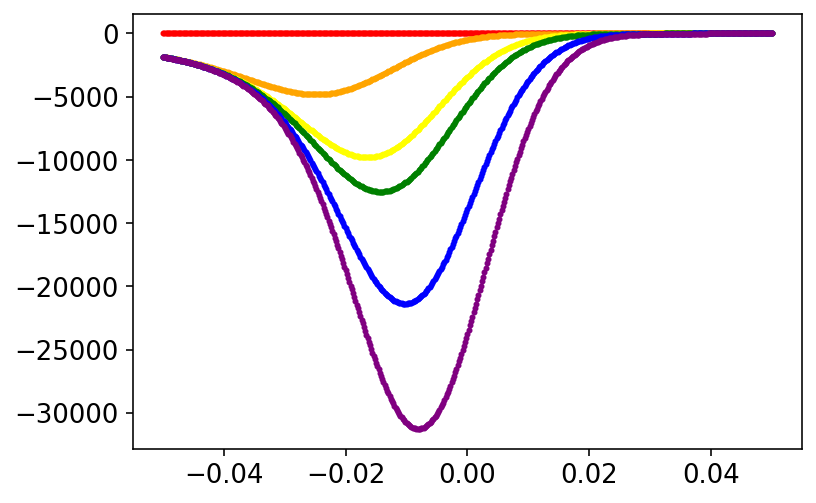

In [12]:
plt.scatter(zvec*10**3,wake_list_E[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_E[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

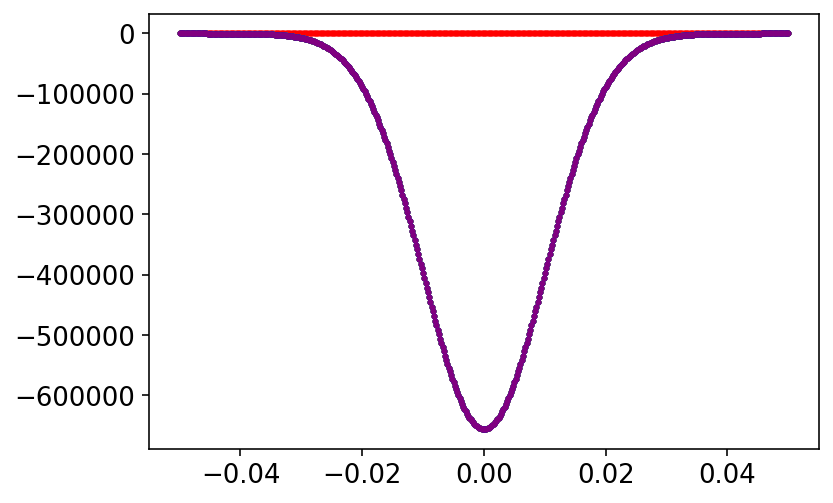

In [90]:
plt.scatter(zvec*10**3,wake_list_E[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_E[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_E[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

# Case A

In [150]:
Es_case_A_grid = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_A', phi =0.1)

component: Es_case_A
Change to internal coordinates...


In [23]:
Fx_case_A_grid = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Fx_case_A', phi =0.1)

component: Fx_case_A
Change to internal coordinates...


In [151]:
def transient_calc_lambda_A_super_phi(phi):
    Es_case_A_grid = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_A', phi = phi)
    
    def transient_calc_lambda_A_super_z(z_observe):
        return transient_calc_lambda_A(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid)
    return np.array(list(map(transient_calc_lambda_A_super_z,zvec)))

In [104]:
jjj = transient_calc_lambda_A_super_phi(0.05)

component: Es_case_A
Change to internal coordinates...


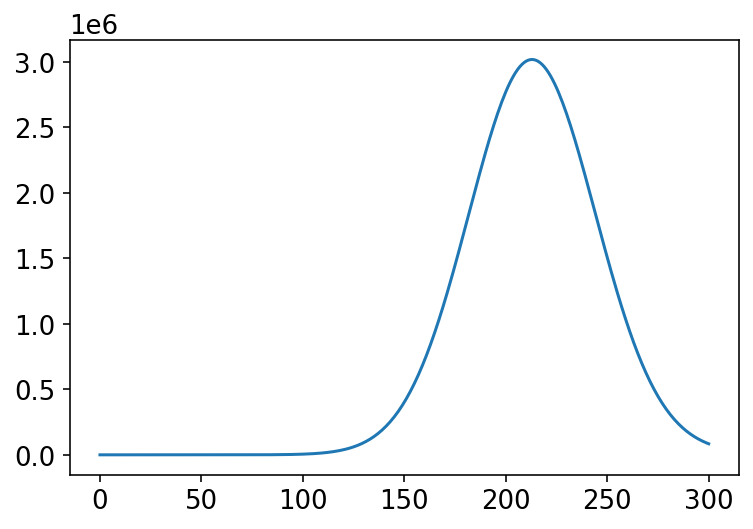

In [105]:
plt.plot(jjj)

In [152]:
def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def plot_Ws_caseA_theory(phi, color, label=None):
    plt.plot(zvec*1e3, 4/phi/rho * lamb_1d( zvec - rho*phi**3/6), color = color, linewidth=4, label = label)
    
def plot_Wx_caseA_theory(phi, color, label=None):
    plt.plot(zvec*1e3, 2/rho * lamb_1d( zvec - rho*phi**3/6), color = color, linewidth=4, label = label)

In [ ]:
#phi_vec = [0.02, 0.03, 0.04, 0.06, 0.08, 0.1]
phi_vec = [0.02, 0.03, 0.05, 0.06, 0.07, 0.08]

wake_list = list(map(transient_calc_lambda_A_super_phi, phi_vec))

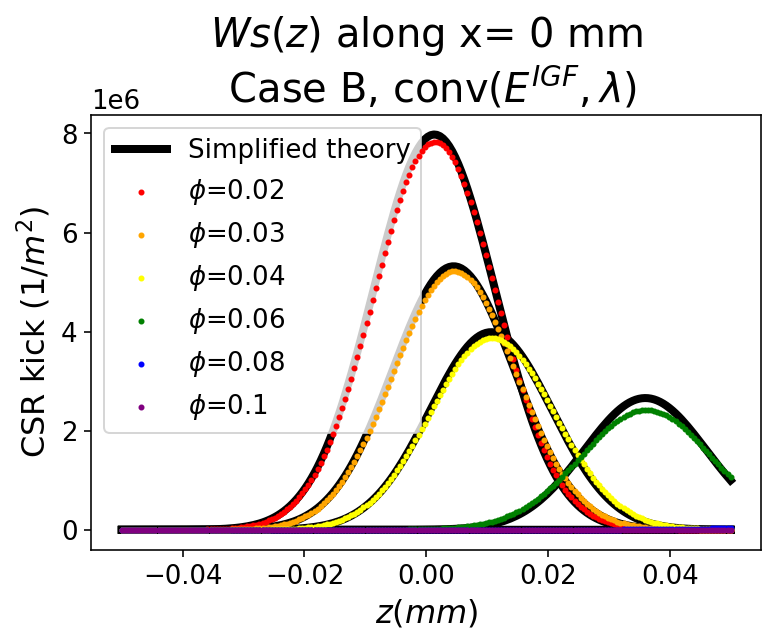

In [154]:
plt.scatter(zvec*10**3,wake_list[0], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list[1], color='orange', label='$\phi$='+str(phi_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[2], color='yellow', label='$\phi$='+str(phi_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[3], color='green', label='$\phi$='+str(phi_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[5], color='purple', label='$\phi$='+str(phi_vec[5]), zorder=10, s=4  )

plot_Ws_caseA_theory(phi_vec[0], 'black', 'Simplified theory')
plot_Ws_caseA_theory(phi_vec[1], 'black')
plot_Ws_caseA_theory(phi_vec[2], 'black')
plot_Ws_caseA_theory(phi_vec[3], 'black')
plot_Ws_caseA_theory(phi_vec[4], 'black')
plot_Ws_caseA_theory(phi_vec[5], 'black')

plt.xlabel('$z(mm)$', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z)$ along x= {x_observe*1000} mm'+'\n Case B, conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='upper left')

# Case B

In [5]:
from csr2d.core2 import alpha_exact_case_B_brentq, Es_case_B
from numba import njit, vectorize, float64
from quantecon.optimize.root_finding import newton 

from scipy import optimize

from scipy.signal import find_peaks 

from scipy import integrate

In [6]:
xval = sigma_x



In [7]:
def Es_case_B_N2(z,x,gamma):
    
    beta2 = 1-1/gamma**2
    beta = np.sqrt(beta2)

    alp = alpha_exact_case_B_brentq(z, x, beta)
    
    sin2a = np.sin(2*alp)
    cos2a = np.cos(2*alp) 

    kap = (2*(alp - z))/beta # kappa for case B
    
    return (1+x)*sin2a - beta*kap

def Es_case_B_N2_z(z):
    return Es_case_B_N2(z,xval,gamma)

In [8]:
optimize.root(Es_case_B_N2_z, -1E-9, tol=1E-9)

    fjac: array([[-1.]])
     fun: array([1.04083409e-17])
 message: 'The solution converged.'
    nfev: 41
     qtf: array([-1.12757026e-17])
       r: array([-178.73579931])
  status: 1
 success: True
       x: array([-1.49042991e-08])

In [11]:
xvec;

In [20]:
def find_Es_case_B_spike(xval):
    """
    Return a list of z values at which Es_case_B(z,xval) has spikes
    """
    def Es_case_B_N2_z(z):
        return Es_case_B_N2(z,xval,gamma)
    
    # First find where N2 ~ 0, and we are close to spike(s)
    op = optimize.root(Es_case_B_N2_z, 0, tol=1E-6)
    if op.success == False:
        #print('no N2 root found!!')
        return [0]
    
    root = op.x[0]

    def Es_case_B_z(z):
        return Es_case_B(z, xval, gamma)
    
    zv = np.linspace( root - 2E-11, root + 2E-11, 2001 ) # The range and resolution are subjected to changes...
    peak_ix = np.union1d(find_peaks( Es_case_B_z(zv))[0], find_peaks( -Es_case_B_z(zv))[0])
    
    return list(zv[peak_ix])
    

Text(0.5, 1.0, 'Es(z) along x = 1.0000000000000002e-06')

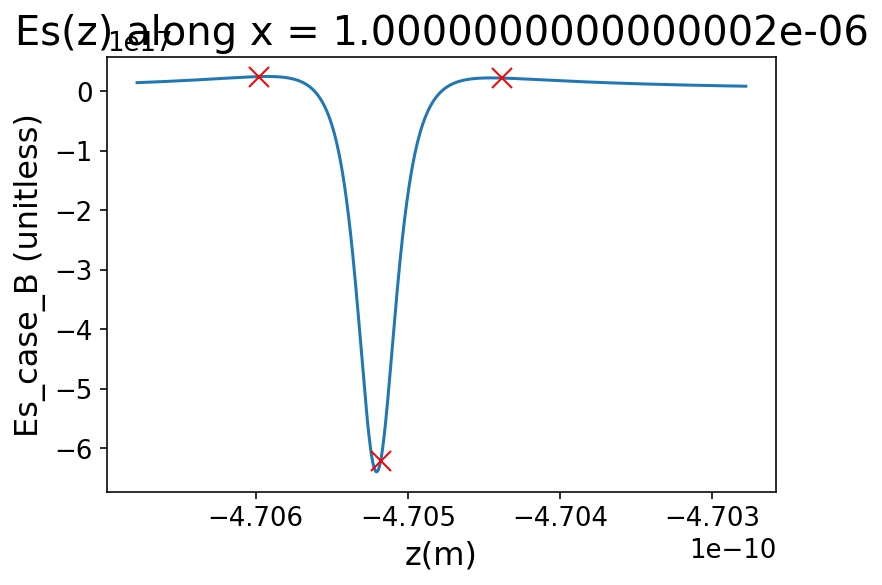

In [23]:
xval = 0.1*sigma_x

def Es_case_B_z(z):
    return Es_case_B(z, xval, gamma)* beta**2/rho**2

def Es_case_B_N2_z(z):
    return Es_case_B_N2(z,xval,gamma)

z_N2_0 = optimize.root(Es_case_B_N2_z, 0, tol=1E-6).x[0]
zv = np.linspace( z_N2_0-2E-13, z_N2_0+ 2E-13, 4001)
#zv = np.linspace( z_N2_0-2E-9, z_N2_0+ 2E-9, 4001)

plt.plot(zv, Es_case_B_z(zv))
#plt.plot(zv[peak_ix], Es_case_D_z(zv)[peak_ix], "x", c='red', markersize=10)

z_spike = find_Es_case_B_spike(xval)

plt.plot(z_spike, Es_case_B_z(z_spike), "x", c='red', markersize=10)

plt.xlabel('z(m)', fontsize=16)
plt.ylabel('Es_case_B (unitless)', fontsize=16)
plt.title(f'Es(z) along x = {xval}',  fontsize=20)

In [53]:
optimize.root(Es_case_B_N2_z, 0, tol=1E-6)

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 3
     qtf: array([0.])
       r: array([5.99697561])
  status: 1
 success: True
       x: array([0.])

In [67]:
z_spike

[-4.70597929855314e-10, -4.70517929855314e-10, -4.704379298553141e-10]

In [76]:
z_obeserve = 0

xval = 0.1*sigma_x

def Es_case_B_z(z):
    return Es_case_B(z, xval, gamma)* beta**2/rho**2

integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = [z_obeserve]+[1000], epsrel=1e-6, limit=50)

/tmp/ipykernel_38578/864499250.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = [z_obeserve]+[1000], epsrel=1e-6, limit=50)


(3448.8739245793454, 31.412219208880288)

In [74]:
points

[0, -4.70597929855314e-10, -4.70517929855314e-10, -4.704379298553141e-10]

In [75]:
points = [z_obeserve]+find_Es_case_B_spike(xval)
integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = points, epsrel=1e-6, limit=50)

/tmp/ipykernel_38578/2941820721.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = points, epsrel=1e-6, limit=50)


(-88.03908272082896, 0.08735536272700994)

In [4]:
Es_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF')

TypeError: find_Es_case_B_spike() missing 1 required positional argument: 'gamma'

In [13]:
Es_case_B_grid_IGF_no_break = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF',include_break_points=False)

/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:223: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(func_z, z-dz/2, z+dz/2, points = points, epsrel=1e-6, limit=100)[0]
/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:223: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func_z, z-dz/2, z+dz/2, points = points, epsrel=1e-6, limit=100)[0]


In [5]:
Es_case_B_grid_IGF.shape

(402, 402)

In [19]:
phi = 0.003
z_observe = 0
x_observe = 0

def transient_calc_lambda_B_super_phi(phi):
    def transient_calc_lambda_B_super_z(z_observe):
        #return transient_calc_lambda_B(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF_no_break)
        return transient_calc_lambda_B(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF)
    return np.array(list(map(transient_calc_lambda_B_super_z,zvec)))

In [15]:
phi_vec = [0.02, 0.03, 0.05, 0.06, 0.09, 0.12]

wake_list = list(map(transient_calc_lambda_B_super_phi, phi_vec))

In [16]:
def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def lamb_1d_prime(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2) * (-z / sigma_z**2)

def plot_Ws_caseB_zi_term_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/phi/rho * lamb_1d( zvec - rho*phi**3/24), color = color, linewidth=4, label = label)
    
def plot_Wx_caseB_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/rho * lamb_1d( zvec ), color = color, linewidth=4, label = label)
    
from scipy import integrate

# Case B integral term ( for large phi this goes to the s-s wake )
def get_Wss(zo):
    w_ss = lambda z: -2/(3*rho**2)**(1/3)*lamb_1d_prime(z)/(zo - z)**(1/3)
    return integrate.quad(w_ss, zo - rho*phi**3/24, zo)[0]

def get_Wzi(zo):
    return -4/phi/rho * lamb_1d( zo - rho*phi**3/24)

def get_Wtot(zo):
    w_ss = lambda z: -2/(3*rho**2)**(1/3)*lamb_1d_prime(z)/(zo - z)**(1/3)
    return -4/phi/rho * lamb_1d( zo - rho*phi**3/24) + integrate.quad(w_ss, zo - rho*phi**3/24, zo)[0]


phi = phi_vec[0]
Wss_list1 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[1]
Wss_list2 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[2]
Wss_list3 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[3]
Wss_list4 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[4]
Wss_list5 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[5]
Wss_list6 = np.array(list(map(get_Wtot, zvec)))


In [17]:
gamma

20000

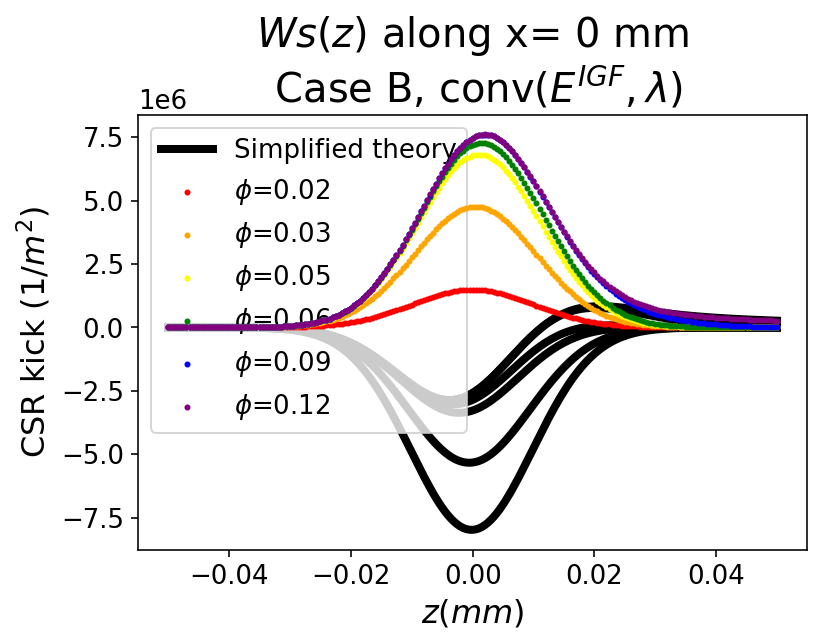

In [18]:
plt.scatter(zvec*10**3,wake_list[0], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list[1], color='orange', label='$\phi$='+str(phi_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[2], color='yellow', label='$\phi$='+str(phi_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[3], color='green', label='$\phi$='+str(phi_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[5], color='purple', label='$\phi$='+str(phi_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, Wss_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, Wss_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list5, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list6, color = 'black', linewidth=4)

plt.xlabel('$z(mm)$', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z)$ along x= {x_observe*1000} mm'+'\n Case B, conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='upper left')

In [ ]:
from mpl_toolkits import mplot3d

dxp = dx/rho
dzp = dz/(2*abs(rho))
zvec2 = np.arange(-nz+1,nz+1,1)*dzp # center = 0 is at [nz-1]
xvec2 = np.arange(-nx+1,nx+1,1)*dxp # center = 0 is at [nx-1]
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z2,X2, Es_case_B_grid_IGF, cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

In [ ]:
np.log(np.max(np.abs(Es_case_B_grid_IGF)))

In [ ]:
if (6!=4) | (3!=5):
    print('lala')

# Case D

In [4]:
x_observe = 0

In [99]:
jaja = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'psi_s')

component: psi_s
Change to internal coordinates...


In [115]:
haha = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_D_IGF', lamb=0.00)

component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 7014 points...


/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:205: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(func_z, z-dz/2, z+dz/2,


Done. Starting midpoint method...


In [108]:
haha2 = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_D', lamb=0.0001)

component: Es_case_D
Change to internal coordinates...


In [7]:
x_observe = 0
phi_m = 0.15/rho
#lamb = 0.008/rho

def transient_calc_lambda_D_super_phi(lamb):
    Es_case_D_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_D_IGF', lamb=lamb)
    
    ## Cheating line?
    #Es_case_D_grid_IGF = np.where(np.abs(Es_case_D_grid_IGF)> 2e9, 0, Es_case_D_grid_IGF)
    
    def transient_calc_lambda_D_super_z(z_observe):
        return transient_calc_lambda_D(phi_m, lamb, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_D_grid_IGF)
    return np.array(list(map(transient_calc_lambda_D_super_z,zvec)))

In [8]:
lamb_vec = [0.0, 0.03, 0.05, 0.06, 0.09, 0.12]
#lamb_vec = [0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
wake_list_D = list(map(transient_calc_lambda_D_super_phi, lamb_vec))

component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 4214 points...
Done. Starting midpoint method...
component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 4214 points...


/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:205: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func_z, z-dz/2, z+dz/2,
/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:205: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(func_z, z-dz/2, z+dz/2,


Done. Starting midpoint method...
component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 4214 points...


/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:205: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func_z, z-dz/2, z+dz/2,


Done. Starting midpoint method...
component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 4214 points...
Done. Starting midpoint method...
component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 4214 points...
Done. Starting midpoint method...
component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 4214 points...
Done. Starting midpoint method...


In [10]:
def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def lamb_1d_prime(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2) * (-z / sigma_z**2)

from scipy import integrate

# Check Dave Sagan's paper ofr the change-of-variable version of the integral 
def get_Wtot_D(zob):
    
    # x here is the exit distance
    x =  lamb*rho
    Lm = phi_m*rho
    def delta_s(l):
        return l**3/24/rho**2*(l + 4*x)/(l + x)
    def delta_s_prime(l):
        return l**2/8/rho**2*(l + 2*x)**2/(l + x)**2
    t1 = - 4 * lamb_1d(zob - delta_s(Lm))/(Lm + 2*x)
    def integrand(l):
        return 4/(l+2*x)* lamb_1d_prime(zob-delta_s(l))*delta_s_prime(l)
    t2 = - integrate.quad( integrand, 0, Lm)[0] 
    
    return t1 + t2
    #if lamb == 0:
    #    return t1 + t2
    #else:
    #    t3 = 4*lamb_1d(zob) /(2*lamb*rho)
    #    return t1 + t2 +t3

# Yunhai's Es case D 1D version (x=0)
from csr2d.core2 import Es_case_D
def get_Wtot_D2(zob):
  
    #zi = rho*(phi_m + lamb - beta* np.sqrt(lamb**2 + 4*np.sin(phi_m/2)**2 +  2*lamb*np.sin(phi_m)))
    #zo = rho*(lamb - beta*lamb)
    zo = 0 
    
    x =  lamb*rho
    zi = rho * phi_m**3/24 *(rho*phi_m + 4*x)/(rho*phi_m + x)
  
    def integrand(zp):
        return Es_case_D((zob - zp)/2/rho, 0, gamma, lamb) * lamb_1d(zp)
    t1 = integrate.quad( integrand, zob-zi, zob-zo)[0] 
      
    return t1

#    if lamb ==0:
#        return t1
#    else:
#        # special boundary term to "match to" 1D theory
#        t2 = 4*lamb_1d(zob - lamb*rho*(1-beta)) /(2*lamb*rho)
#        return t1 - t2

from csr2d.core2 import alpha_exact_case_D_brentq, alpha_exact_case_D

def get_Wtot_D3(zob):
  
    #zi = rho*(phi_m + lamb - beta* np.sqrt(lamb**2 + 4*np.sin(phi_m/2)**2 +  2*lamb*np.sin(phi_m)))
    zo = rho*(lamb - beta*lamb)
    
    x =  lamb*rho
    zi = rho * phi_m**3/24 *(rho*phi_m + 4*x)/(rho*phi_m + x)
    #zo = 0
  
    def integrand(zp):
        return 2/alpha_exact_case_D_brentq((zob-zp), 0, beta, lamb)**4 * lamb_1d(zp)
        #return 2/alpha_exact_case_D((zob - zp), 0, beta, lamb)**4 * lamb_1d(zp)
    t1 = integrate.quad( integrand, zob-zi, zob-zo)[0] 
    return t1

def get_Wtot_D4(zob):
    
    # x here is the exit distance
    x =  lamb*rho
    Lm = phi_m*rho
    
    zo = rho*(lamb - beta*lamb)
    zi = rho * phi_m**3/24 *(rho*phi_m + 4*x)/(rho*phi_m + x)
    
    # t1 = 4 * lamb_1d(zob - zi)/(rho*phi_m + 2*x)
    
    def integrand(zp):
        the = alpha_exact_case_D_brentq((zob-zp)/2/rho, 0, beta, lamb)/2
        return 1/(rho*the + 2*x) * lamb_1d_prime(zp)
    t2 = -4*integrate.quad( integrand, zob-zi, zob-zo)[0] 
    return t2

In [202]:
lamb = 0.000001
x =  lamb*rho
lamb_1d(0-rho * phi_m**3/24 *(rho*phi_m + 4*x)/(rho*phi_m + x))

4.544407436968867e-39

In [11]:
#lamb_vec = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]

lamb_vec = [0.0, 0.03, 0.05, 0.06, 0.09, 0.12]

phi_m = 0.15/rho
lamb = lamb_vec[0]
WsD_list1 = np.array(list(map(get_Wtot_D, zvec)))
lamb = lamb_vec[1]
WsD_list2 = np.array(list(map(get_Wtot_D, zvec)))
lamb = lamb_vec[2]
WsD_list3 = np.array(list(map(get_Wtot_D, zvec)))
lamb = lamb_vec[3]
WsD_list4 = np.array(list(map(get_Wtot_D, zvec)))
lamb = lamb_vec[4]
WsD_list5 = np.array(list(map(get_Wtot_D, zvec)))
lamb = lamb_vec[5]
WsD_list6 = np.array(list(map(get_Wtot_D, zvec)))

In [14]:
phi_m = 0.15/rho   # large enough to enter s-s before the magnet exit
lamb_vec = [0.0, 0.03, 0.05, 0.06, 0.09, 0.12]

lamb = lamb_vec[0]
WsD2_list1 = np.array(list(map(get_Wtot_D2, zvec)))
lamb = lamb_vec[1]
WsD2_list2 = np.array(list(map(get_Wtot_D2, zvec)))
lamb = lamb_vec[2]
WsD2_list3 = np.array(list(map(get_Wtot_D2, zvec)))
lamb = lamb_vec[3]
WsD2_list4 = np.array(list(map(get_Wtot_D2, zvec)))
lamb = lamb_vec[4]
WsD2_list5 = np.array(list(map(get_Wtot_D2, zvec)))
lamb = lamb_vec[5]
WsD2_list6 = np.array(list(map(get_Wtot_D2, zvec)))

/tmp/ipykernel_56678/4140031093.py:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  t1 = integrate.quad( integrand, zob-zi, zob-zo)[0]
/tmp/ipykernel_56678/4140031093.py:43: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t1 = integrate.quad( integrand, zob-zi, zob-zo)[0]
/tmp/ipykernel_56678/4140031093.py:43: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best 

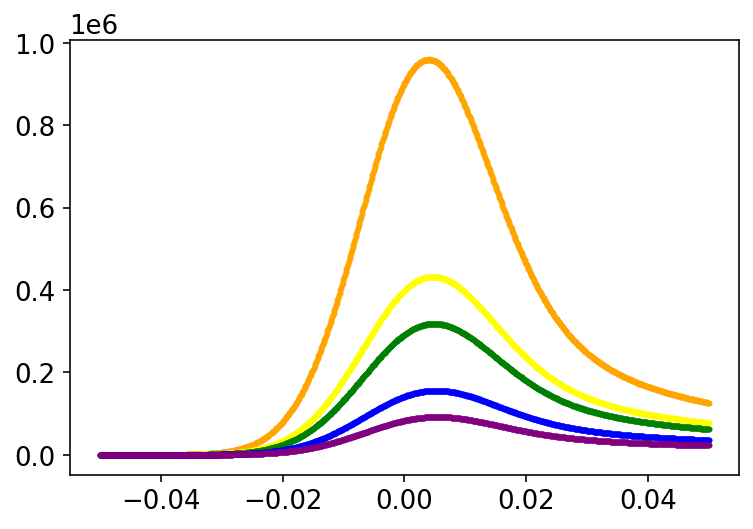

In [29]:
#plt.scatter(zvec*10**3,wake_list_D[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_D[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

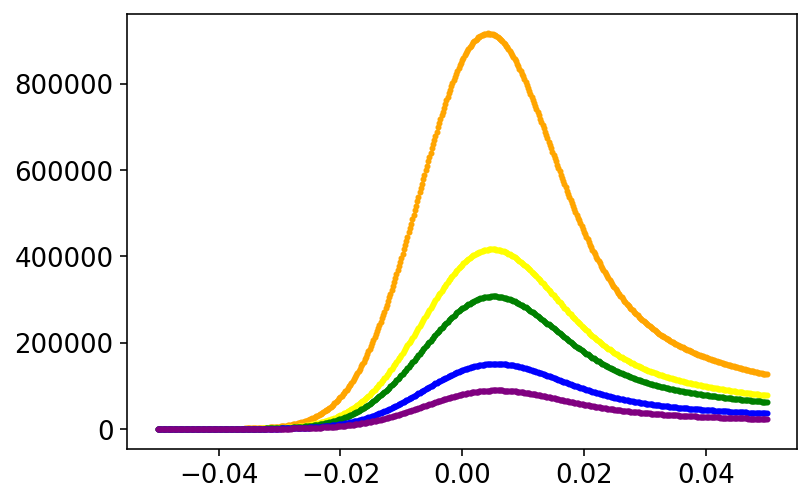

In [17]:
#plt.scatter(zvec*10**3,wake_list_D[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_D[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

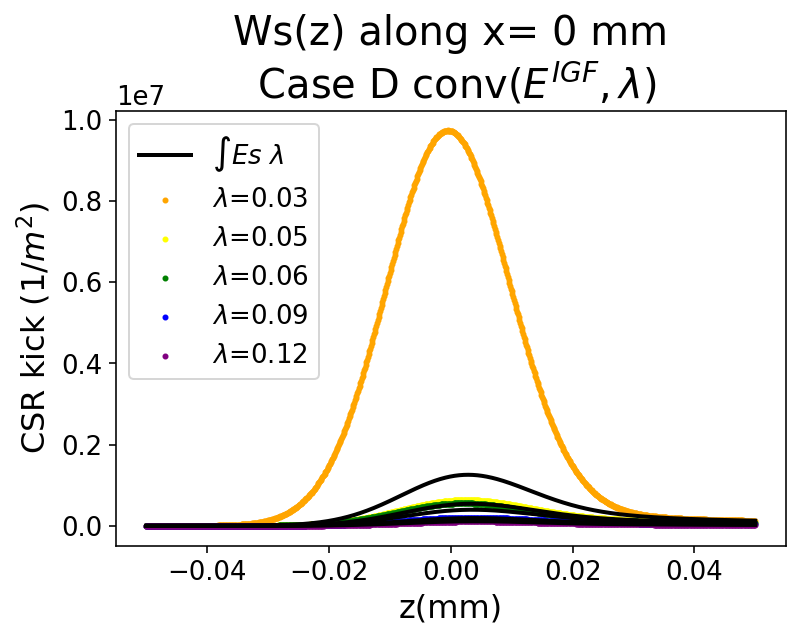

In [21]:
#plt.scatter(zvec*10**3,wake_list_D[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_D[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

#plt.plot(zvec*1e3, WsD_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, WsD2_list2, color = 'black', linewidth=2, label = fr'$\int Es ~ \lambda$', zorder=12)
plt.plot(zvec*1e3, WsD2_list3, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD2_list4, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD2_list5, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD2_list6, color = 'black', linewidth=2, zorder=12)

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'Ws(z) along x= {x_observe*1000} mm'+'\n Case D conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='upper left')

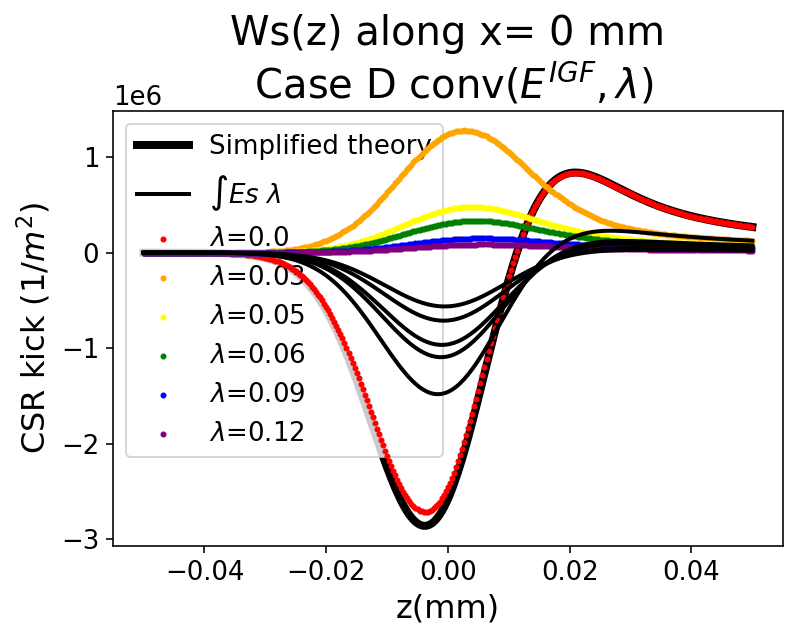

In [14]:
plt.scatter(zvec*10**3,wake_list_D[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_D[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, WsD_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, WsD_list2, color = 'black', linewidth=2, label = fr'$\int Es ~ \lambda$', zorder=12)
plt.plot(zvec*1e3, WsD_list3, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD_list4, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD_list5, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD_list6, color = 'black', linewidth=2, zorder=12)

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'Ws(z) along x= {x_observe*1000} mm'+'\n Case D conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='upper left')

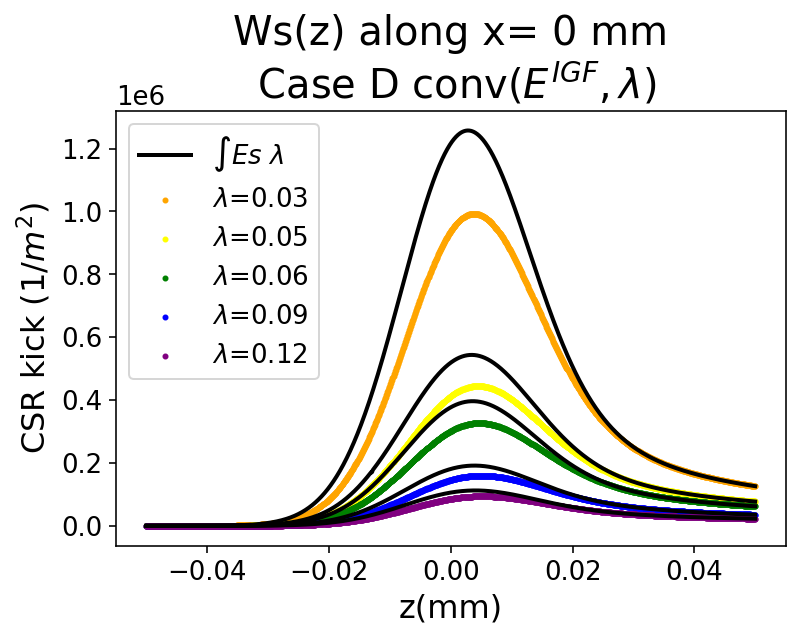

In [54]:
#plt.scatter(zvec*10**3,wake_list_D[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_D[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

#plt.plot(zvec*1e3, WsD_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, WsD2_list2, color = 'black', linewidth=2, label = fr'$\int Es ~ \lambda$', zorder=12)
plt.plot(zvec*1e3, WsD2_list3, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD2_list4, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD2_list5, color = 'black', linewidth=2, zorder=12)
plt.plot(zvec*1e3, WsD2_list6, color = 'black', linewidth=2, zorder=12)

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'Ws(z) along x= {x_observe*1000} mm'+'\n Case D conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='upper left')

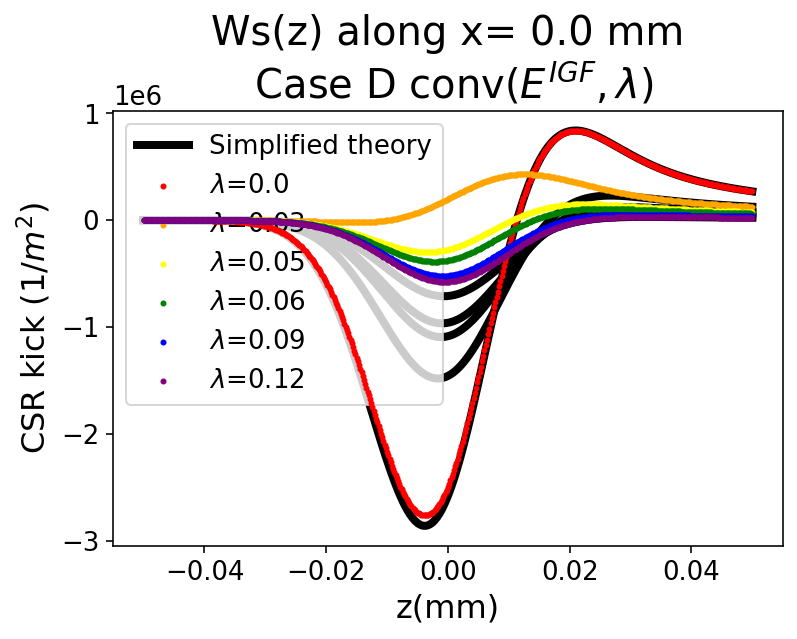

In [94]:
plt.scatter(zvec*10**3,wake_list_D[0] + wake_list_E[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_D[1] + wake_list_E[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[2] + wake_list_E[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[3] + wake_list_E[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[4] + wake_list_E[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[5] + wake_list_E[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, WsD_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, WsD_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list5, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list6, color = 'black', linewidth=4)

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'Ws(z) along x= {x_observe*1000} mm'+'\n Case D conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='upper left')

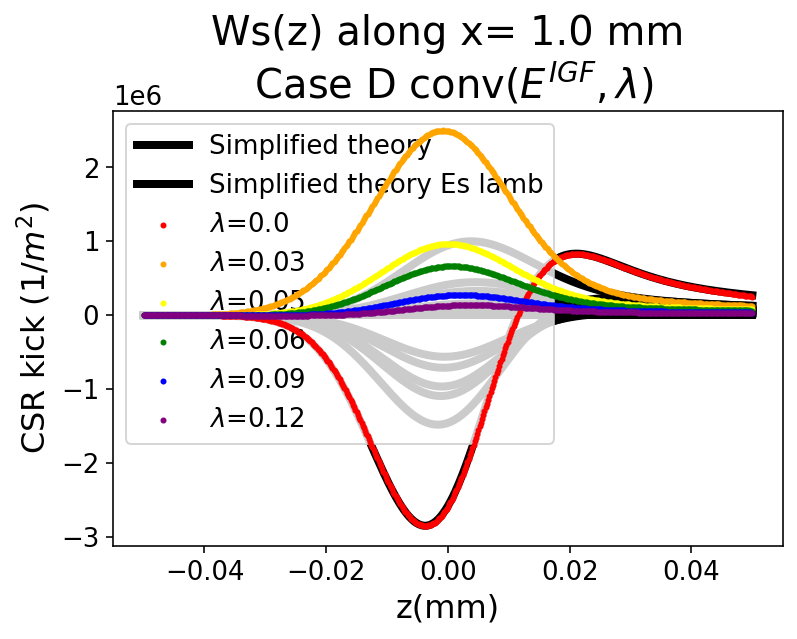

In [169]:
plt.scatter(zvec*10**3,wake_list_D[0] + wake_list_E[0], color='red', label='$\lambda$='+str(lamb_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_D[1] + wake_list_E[1], color='orange', label='$\lambda$='+str(lamb_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[2] + wake_list_E[2], color='yellow', label='$\lambda$='+str(lamb_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[3] + wake_list_E[3], color='green', label='$\lambda$='+str(lamb_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[4] + wake_list_E[4], color='blue', label='$\lambda$='+str(lamb_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_D[5] + wake_list_E[5], color='purple', label='$\lambda$='+str(lamb_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, WsD_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, WsD_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list5, color = 'black', linewidth=4)
plt.plot(zvec*1e3, WsD_list6, color = 'black', linewidth=4)


plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'Ws(z) along x= {x_observe*1000} mm'+'\n Case D conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='upper left')